In [384]:
import pypsa
import matplotlib.pyplot as plt
import pandas as pd
from myUtils import *

# rootPath = "../../results/scenario/geothermal"
# rootPath = "../../results/scenario/biogas"
# rootPath = "../../results/scenario/PHS"
rootPath = "../../results/scenario/PHS"
# rootPath = "../../results/scenario/battery"
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')
sns.color_palette("muted", 14)
%matplotlib inline

# n = pypsa.Network("../../results/base/base27Node2045/postnetworks/base_s_27_lvopt_3H_3H_2045.nc")
# nMean = pypsa.Network(rootPath + "-mean/postnetworks/base_s_27_lvopt_3H_3H_2045.nc")
# nOptimist = pypsa.Network(rootPath + "-optimist/postnetworks/base_s_27_lvopt_3H_3H_2045.nc")
# n = pypsa.Network(rootPath + "/postnetworks/base_s_27_lvopt_3H_3H_2045.nc")

# n = pypsa.Network("../../results/scenario/h2-best/postnetworks/base_s_27_lvopt_3H_3H_2045.nc")
# n = pypsa.Network("../../results/scenario/h2-de/postnetworks/base_s_20_lvopt_3H_3H_2045.nc")
# n = pypsa.Network("../../results/scenario-old/h2-idea/postnetworks/base_s_27_lc1_3H_3H_2045.nc")
n = pypsa.Network("../../results/scenario/ror_mean/networks/base_s_27_3H_3H_2045.nc")


INFO:pypsa.io:Imported network base_s_27_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


```
1 kW= 1e3 W               1 KWH = 1e3 WH             1 Tsd EUR = 1e3 EUR
1 MW = 1e6 W = 1 MW       1 MWH = 1e6 WH = 1 MWH     1 Mio.EUR = 1e6 EUR
1 GW = 1e9 W = 1e3 MW     1 GWH = 1e9 WH = 1e3 MWH   1 Mrd.EUR = 1e9 EUR
1 TW = 1e12 W = 1e6 MW    1 TWH = 1e12 WH = 1e6 MWH  1 Bio.EUR = 1e12 EUR


```

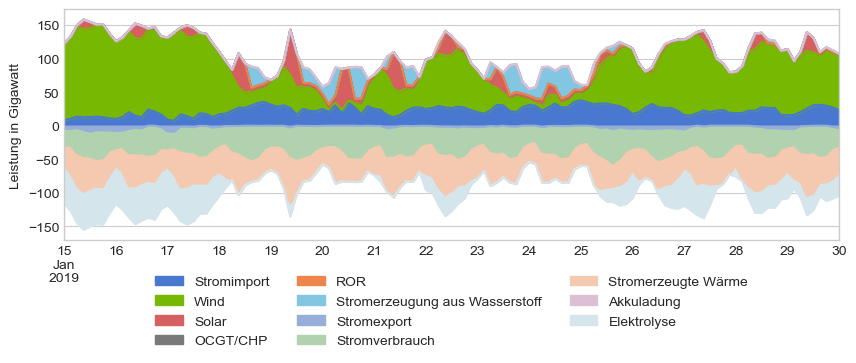

In [383]:
import pandas as pd
import myUtils as utils
import importlib
from matplotlib.dates import DateFormatter


importlib.reload(utils)


df = pd.DataFrame(index = n.snapshots)

# supply

importLinkIds = utils.de_import_elec_grouper(n, 'Link').tolist()
importLinIds = utils.de_import_elec_grouper(n, 'Line').tolist()
importLineRIDS = utils.de_import_elec_reverse_grouper(n, 'Line').tolist()

df['Stromimport'] = - n.links_t.p1[importLinkIds].sum(axis=1) \
  - n.lines_t.p1[importLinIds].clip(upper=0).sum(axis=1) \
  - n.lines_t.p0[importLineRIDS].clip(upper=0).sum(axis=1)


generatorGeneratorIds =  utils.de_generator_grouper(n, 'Generator').tolist()
generatorLinkIds =  utils.de_generator_grouper(n, 'Link').tolist()


windGeneratorP = utils.getNTimePropByGroup(n, 'Generator', 'p', utils.de_wind_generator_grouper)
df['Wind'] =  windGeneratorP.sum(axis=1)
pvGeneratorP = utils.getNTimePropByGroup(n, 'Generator', 'p', utils.de_pv_generator_grouper)
df['Solar'] =  pvGeneratorP.sum(axis=1)
co2GeneratorP = - utils.getNTimePropByGroup(n, 'Link', 'p1', utils.de_co2_generator_grouper)
biomassGeneratorP = - utils.getNTimePropByGroup(n, 'Link', 'p1', utils.de_biomass_generator_grouper)

rorGeneratorP = utils.getNTimePropByGroup(n, 'Generator', 'p', utils.de_ror_generator_grouper)
geothermalGeneratorP = utils.getNTimePropByGroup(n, 'Link', 'p1', utils.de_geothermal_generator_grouper)

# df['Geothermie'] = - geothermalGeneratorP.sum(axis=1)

df['OCGT/CHP'] =  co2GeneratorP.sum(axis=1) 
df['ROR'] =  rorGeneratorP.sum(axis=1) 
# df['Biomasse']=biomassGeneratorP.sum(axis=1)

# demand

storeStorageIds = utils.de_elec_store_grouper(n, 'StorageUnit').tolist()
storeStoreIds = utils.de_elec_store_grouper(n, 'Store').tolist()
# df['Entladung'] = n.storage_units_t.p_dispatch[storeStorageIds].sum(axis=1) \
#   + n.stores_t.p[storeStoreIds].clip(lower=0).sum(axis=1)
# df['V2G'] = n.storage_units_t.p_dispatch[storeStorageIds].sum(axis=1) \
#   + n.stores_t.p[storeStoreIds].clip(lower=0).sum(axis=1)

ids = utils.de_h2_dispatch_grouper(n, 'Link').tolist()
# df['Stromerzeugung aus Wasserstoff'] = - n.links_t.p1[ids].sum(axis=1)
# use
exportLinkIds = utils.de_export_elec_grouper(n, 'Link').tolist()
exportLinIds = utils.de_export_elec_grouper(n, 'Line').tolist()

df['Stromexport'] = - n.links_t.p0[exportLinkIds].sum(axis=1) \
  - n.lines_t.p0[exportLinIds].clip(lower=0).sum(axis=1) \
  # - n.lines_t.p1[importLineRIDS].clip(upper=0).sum(axis=1)


useLoadIds = utils.de_elec_use_grouper(n, 'Load').tolist()
useLinesWasteIds = utils.getIndexSeries(n.df('Line'), utils.getIndexDeInnerCarrier(n.df('Line'), 'AC'))
distributionP0 = utils.getNTimePropByGroup(n, 'Link', 'p0', utils.de_elec_distrbution_use_grouper) 
distributionP1 = utils.getNTimePropByGroup(n, 'Link', 'p1', utils.de_elec_distrbution_use_grouper) 



df['Stromverbrauch'] = - n.loads_t.p[useLoadIds].sum(axis=1)  \
  - utils.getNTimePropByGroup(n, 'Link', 'p2', utils.de_elec_methanol_use).sum(axis=1) \
  - (n.lines_t.p0[useLinesWasteIds] + n.lines_t.p1[useLinesWasteIds]).sum(axis=1) \
  - (distributionP0 + distributionP1).sum(axis=1)
useLinkIds = utils.de_elec_use_grouper(n, 'Link').tolist()   
df['Stromerzeugte Wärme'] =  -n.links_t.p0[useLinkIds].clip(lower=0).sum(axis=1)

storeStorageIds = utils.de_elec_store_grouper(n, 'StorageUnit').tolist()


storeStoreIds = utils.de_elec_store_grouper(n, 'Store').tolist()
useElectrolysisIds = utils.de_h2_Electrolysis_grouper(n, 'Link').tolist()
df['Akkuladung'] =  n.storage_units_t.p[storeStorageIds].clip(upper=0).sum(axis=1)\
  + n.stores_t.p[storeStoreIds].clip(upper=0).sum(axis=1) 

df['Elektrolyse'] = - n.links_t.p0[useElectrolysisIds].sum(axis=1) 

# total_use = (df['export'] + df['use']  + df['heat'])
# total_produce= (df['import'] + df['PV generator'] + df['dispatch'])
# print(n.statistics.capex(groupby="de_grouper").sum() / 1e9) # 71
# print(n.statistics.opex(groupby="de_grouper").sum() / 1e9) # 5

colors = {
  'Stromimport': '#4878D0',
  'Stromerzeugung aus Wasserstoff': '#82C6E2',
  'Entladung': '#DC7EC0',
   'V2G': '#DC7EC0',
  
  'Wind': '#76B802',
  'Solar': '#D65F5F',
  'Geothermie': '#D5BB67',
  'OCGT/CHP': '#797979',
  'ROR': '#EE854A',
  'Biomasse': '#8C613C',

  'Stromexport': '#97AED9',
  'Elektrolyse': '#D5E5EC',
  'Akkuladung': '#DEBED4',

  'Stromverbrauch': '#B1D2AF',
  'Stromerzeugte Wärme': '#F4C9B0',
}
df = df / 1e3

ax = df['2019-1-15 00:00:00': '2019-1-30 00:00:00'].plot(kind='area', figsize=(10,3), color=colors )
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False)
# ax.xaxis.set_major_formatter(DateFormatter(" %d %m"))
ax.set_ylabel('Leistung in Gigawatt')
ax.set_xlabel('')


area_colors = [polygon.get_facecolor() for polygon in ax.collections]
area_colors_rgb = [color[:3] for color in area_colors]


plt.show()


In [355]:
generator_df = utils.getNByGroup(n, 'Generator', utils.de_generator_grouper)
generators = generator_df.groupby('carrier').sum().p_nom_opt / 1e3
g_links_df = utils.getNByGroup(n, 'Link', utils.de_generator_grouper)
generatorLinks = g_links_df.groupby('carrier').sum().p_nom_opt / 1e3

h2_df = utils.getNByGroup(n, 'Link', utils.de_h2_dispatch_grouper)
h2s =  h2_df.groupby('carrier').sum().p_nom_opt / 1e3

biomass = utils.getNByGroup(n,'Link',utils.de_biomass_chp)
  # print(biomass)
s = pd.concat([generators, generatorLinks,h2s])
s['Offwind'] = s['offwind-ac'] + s['offwind-dc'] + s['offwind-float']
s['Solar'] = s['solar'] + s['solar-hsat']
s['Onwind'] = s['onwind']
  

s['Solardach'] = s['solar rooftop']
s['Erdgas CHP'] = s['urban central CHP']
s['Geothermal'] = s.get('geothermal organic rankine cycle', 0)
s['Biomasse CHP'] = biomass.p_nom_opt.sum() 
s['Gesamt'] = s.sum()
  
s = s.reindex(['Onwind', 'Offwind', 'Solar', 'Solardach','OCGT','Erdgas CHP', 'Geothermal','H2 Fuel Cell', 'H2 turbine', 'Biomasse CHP', 'ror', 'Gesamt'])
s

carrier
Onwind           77.11256
Offwind          78.32878
Solar            50.28736
Solardach       100.12860
OCGT             71.86041
Erdgas CHP       52.52488
Geothermal        0.00000
H2 Fuel Cell          NaN
H2 turbine            NaN
Biomasse CHP   4412.39126
ror                   NaN
Gesamt         5201.01603
Name: p_nom_opt, dtype: float64

In [346]:
import pandas as pd
import myUtils as utils
import importlib
importlib.reload(utils)


def getDfValue (n):
  lists = [
    n.statistics.capex().sum() / 1e9,
    n.statistics.capex(groupby="de_grouper").sum() / 1e9,
    n.statistics.expanded_capex(groupby="de_grouper").sum() / 1e9,
    n.statistics.opex(groupby="de_grouper").sum() / 1e9,

    n.statistics.capex(groupby="de_all_generator_grouper").sum() / 1e9,
    n.statistics.opex(groupby="de_all_generator_grouper").sum() / 1e9,
  ]
  return lists

data = {
  'Name': [
    "CAPEX(inkl. Nachbarländer)",
    "CAPEX",
    "investierte CAPEX",
    "OPEX",

    "Strom CAPEX",
    "Strom Opex"
  ],
  # 'Unit': [
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR'
  # ],
  'Base': getDfValue(n),
}
print(len(data['Name']), len(data['Name']), len(data['Base']))



df = pd.DataFrame(data).set_index('Name')

# caepx_base = df.loc['CAPEX', 'Base']
# caepx_changes = (df.loc['CAPEX', ['Mean', 'Optimist', 'Best']] - caepx_base) / caepx_base * 100

# elc_caepx_base = df.loc['Strom CAPEX', 'Base']
# elc_caepx_changes = (df.loc['Strom CAPEX', ['Mean', 'Optimist', 'Best']] - elc_caepx_base) / elc_caepx_base * 100

# table = utils.dataframe_to_table(df)
# print(table)
# print(caepx_changes)
# print(elc_caepx_changes)

print(df)

6 6 6
                                Base
Name                                
CAPEX(inkl. Nachbarländer) 631.55930
CAPEX                       83.01483
investierte CAPEX           71.42811
OPEX                         4.84957
Strom CAPEX                 29.36424
Strom Opex                   0.04402


In [343]:
n1 = pypsa.Network("../../results/scenario/h2_good/networks/base_s_27_3H_3H_2045.nc")
n2 = pypsa.Network("../../results/scenario/flex_mean_1/networks/base_s_27_3H_3H_2045.nc")

series1 = utils.getNByGroup(n1,'Generator', utils.de_pv_generator_grouper)['p_nom_max']
series2 =  utils.getNByGroup(n2,'Generator', utils.de_pv_generator_grouper)['p_nom_max']
df = pd.concat([series1, series2], axis=1)
print (df)

INFO:pypsa.io:Imported network base_s_27_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


FileNotFoundError: [Errno 2] No such file or directory: '/Users/maxiao/Documents/code/rli-code/pypsa-eur-flexibility/results/scenario/flex_mean_1/networks/base_s_27_3H_3H_2045.nc'